#### Prediction of Celltypes with Autogated Results

In [16]:
import pandas as pd
import numpy as np
import sklearn
import anndata as ad

#### Prediction Steps
1. Map autogated predictions to anndata
2. Split data by regions
3. Group 70% as training (wrt region) and 30% as testing
4. Apply two layer MLP

#### Step 1: Data Cleaning - Merging Autogated Predictions with Anndata

In [30]:
# Map autogating results to the original data
autogated = pd.read_csv('/mnt/disks/ecdyer-disk1/cell_type_assignments/scimap_auto_gating.csv')
autogated.rename(columns={'CellID': 'cell_id'}, inplace=True)

# Load adata object
adata = ad.read_h5ad('/mnt/disks/ecdyer-disk1/data/mel01_3_1_embeddings.h5ad')

# Ensure the DataFrame index matches the AnnData obs_names
autogated.set_index('cell_id', inplace=True)  # Replace 'cell_id' with the actual column name in your DataFrame

# Set 'cell_id' as index in adata.obs
adata.obs.set_index('cell_id', inplace=True)

In [36]:
# Save the updated AnnData object
adata.write('/mnt/disks/ecdyer-disk1/data/updated_mel01_3_1_embeddings.h5ad')

In [37]:
matched_adata = ad.read_h5ad('/mnt/disks/ecdyer-disk1/data/autogated_mel01_3_1_embeddings.h5ad')

/mnt/disks/ecdyer-disk1/miniconda3/envs/data_jam/lib/python3.9/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [34]:
matched_adata.obs

,cell_id,roi_im_fnames,region_names,region_id,row_index,col_index,image_sample_name,htan_image_id,patient_outcome,image_histology,patch_centroids_row_orig,patch_centroids_col_orig,patch_centroids_row_adj,patch_centroids_col_adj,patch_fname,boundary_status,updated_phenotypes
0,182870,MEL01-3-1_roi_532_row_8800_col_37440.ome.tif,MEL01-3-1_roi_532_row_8800_col_37440,532,8800,37440,MEL01-3-1,HTA7_1_9,Recurrence,Superficial Spreading Melanoma,8802.828025,38665.305732,2.828025,1225.305732,MEL01-3-1_roi_532_row_8800_col_37440_patch_0.tiff,border,Tumor
1,182906,MEL01-3-1_roi_532_row_8800_col_37440.ome.tif,MEL01-3-1_roi_532_row_8800_col_37440,532,8800,37440,MEL01-3-1,HTA7_1_9,Recurrence,Superficial Spreading Melanoma,8800.314961,37795.598425,0.314961,355.598425,MEL01-3-1_roi_532_row_8800_col_37440_patch_1.tiff,border,Tumor
2,182908,MEL01-3-1_roi_532_row_8800_col_37440.ome.tif,MEL01-3-1_roi_532_row_8800_col_37440,532,8800,37440,MEL01-3-1,HTA7_1_9,Recurrence,Superficial Spreading Melanoma,8800.876847,38026.689655,0.876847,586.689655,MEL01-3-1_roi_532_row_8800_col_37440_patch_2.tiff,border,Dendritic cell
3,182946,MEL01-3-1_roi_532_row_8800_col_37440.ome.tif,MEL01-3-1_roi_532_row_8800_col_37440,532,8800,37440,MEL01-3-1,HTA7_1_9,Recurrence,Superficial Spreading Melanoma,8800.463964,37564.418919,0.463964,124.418919,MEL01-3-1_roi_532_row_8800_col_37440_patch_3.tiff,border,Dendritic cell
4,182947,MEL01-3-1_roi_532_row_8800_col_37440.ome.tif,MEL01-3-1_roi_532_row_8800_col_37440,532,8800,37440,MEL01-3-1,HTA7_1_9,Recurrence,Superficial Spreading Melanoma,8800.573991,37587.973094,0.573991,147.973094,MEL01-3-1_roi_532_row_8800_col_37440_patch_4.tiff,border,Tumor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563166,397358,MEL01-3-1_roi_849_row_14400_col_39520.ome.tif,MEL01-3-1_roi_849_row_14400_col_39520,849,14400,39520,MEL01-3-1,HTA7_1_9,Recurrence,Superficial Spreading Melanoma,15197.607287,40045.615385,797.607287,525.615385,MEL01-3-1_roi_849_row_14400_col_39520_patch_19...,non-border,Tumor
563167,397359,MEL01-3-1_roi_849_row_14400_col_39520.ome.tif,MEL01-3-1_roi_849_row_14400_col_39520,849,14400,39520,MEL01-3-1,HTA7_1_9,Recurrence,Superficial Spreading Melanoma,15198.424812,40437.992481,798.424812,917.992481,MEL01-3-1_roi_849_row_14400_col_39520_patch_19...,non-border,Tumor
563168,397413,MEL01-3-1_roi_849_row_14400_col_39520.ome.tif,MEL01-3-1_roi_849_row_14400_col_39520,849,14400,39520,MEL01-3-1,HTA7_1_9,Recurrence,Superficial Spreading Melanoma,15197.411321,39790.943396,797.411321,270.943396,MEL01-3-1_roi_849_row_14400_col_39520_patch_19...,non-border,Tumor
563169,397459,MEL01-3-1_roi_849_row_14400_col_39520.ome.tif,MEL01-3-1_roi_849_row_14400_col_39520,849,14400,39520,MEL01-3-1,HTA7_1_9,Recurrence,Superficial Spreading Melanoma,15199.081301,40400.731707,799.081301,880.731707,MEL01-3-1_roi_849_row_14400_col_39520_patch_19...,non-border,Tumor


#### Step 2: Split Data by Regions and Create Test/Train Splits

In [56]:
# Drop all 'unassigned' cells
matched_adata = matched_adata[matched_adata.obs['updated_phenotypes'] != 'unassigned']

# Create Validation Region File
# Validation region (for visualization)
validation_region = 'MEL01-3-1_roi_573_row_9600_col_33280'
validation_obs = matched_adata.obs[matched_adata.obs['region_names'] == validation_region]

# Create a new AnnData object with the filtered data
filtered_anndata = matched_adata[validation_obs.index].copy()

# Save the new AnnData object if needed
filtered_anndata.write('/mnt/disks/ecdyer-disk1/data/validation-viz-region.h5ad') 

In [57]:
# Drop rows with region_names equal to validation_region
no_val_adata = matched_adata[matched_adata.obs['region_names'] != validation_region].copy()

In [58]:
# Step 1: Calculate the total number of cells
total_cells = no_val_adata.n_obs

# Step 2: Calculate the target number of cells (70% of total)
target_cells = total_cells * 0.9

# Step 3: Group by 'region_names' and count the number of cells in each region
region_counts = (
    no_val_adata.obs.groupby('region_names')
    .size()
    .reset_index(name='cell_count')
)

# Step 4: Shuffle the 'region_names' to randomize
shuffled_regions = region_counts.sample(
    frac=1, random_state=42
).reset_index(drop=True)

# Step 5: Accumulate regions until reaching approximately 70% of total cells
cumulative_cells = 0
selected_regions = []

for idx, row in shuffled_regions.iterrows():
    cumulative_cells += row['cell_count']
    selected_regions.append(row['region_names'])
    if cumulative_cells >= target_cells:
        break

# Create a boolean mask for the selected regions
mask = no_val_adata.obs['region_names'].isin(selected_regions)

# Step 6: Split the AnnData object into two datasets
adata_90 = no_val_adata[mask].copy()
adata_10 = no_val_adata[~mask].copy()


/tmp/ipykernel_259633/4268371820.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  no_val_adata.obs.groupby('region_names')


In [59]:
# Save the splits
adata_90.write('/mnt/disks/ecdyer-disk1/data/90_split.h5ad')
adata_10.write('/mnt/disks/ecdyer-disk1/data/10_split.h5ad')

#### Step 3: Train MLP

In [60]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import KFold

In [68]:
# Check embeddings shape
print(adata_90.X.shape)

(402875, 768)


In [61]:
# Check that GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [62]:
# Define Dataset class

class mIFDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

In [63]:
# Define a simple MLP model

class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size), #input layer
            nn.ReLU(), # activation layer
            nn.Linear(hidden_size, num_classes) # output layer
        )

    def forward(self, x):
        return self.model(x)

In [71]:
# Hyperparameters
input_size = 768        # Size of the image patch embeddings
hidden_size = 256       # Number of neurons in the hidden layer
num_classes = adata_90.obs['updated_phenotypes'].nunique()         # Number of output classes
num_epochs = 10         # Number of training epochs per fold
batch_size = 64        # Batch size for DataLoader
learning_rate = 0.001  # Learning rate for optimizer
num_folds = 3          # Number of folds for cross-validation


# Input Data
num_samples = 402875
embeddings = torch.tensor(adata_90.X, dtype=torch.float32).to(device)
labels = torch.tensor(adata_90.obs['updated_phenotypes'].cat.codes.values, dtype=torch.long).to(device)

# Create Dataset
training_dataset = mIFDataset(embeddings, labels)

# Output Directory
output_dir = '/mnt/disks/ecdyer-disk1/results/'

Fold 1/3
--------------------------------
Epoch [1/10], Training Loss: 0.4976, Training Accuracy: 82.02%, Validation Loss: 0.4717, Validation Accuracy: 82.75%
Epoch [2/10], Training Loss: 0.4613, Training Accuracy: 83.20%, Validation Loss: 0.4651, Validation Accuracy: 83.27%
Epoch [3/10], Training Loss: 0.4482, Training Accuracy: 83.62%, Validation Loss: 0.4562, Validation Accuracy: 83.38%
Epoch [4/10], Training Loss: 0.4397, Training Accuracy: 83.91%, Validation Loss: 0.4596, Validation Accuracy: 83.28%
Epoch [5/10], Training Loss: 0.4339, Training Accuracy: 84.10%, Validation Loss: 0.4526, Validation Accuracy: 83.62%
Epoch [6/10], Training Loss: 0.4285, Training Accuracy: 84.29%, Validation Loss: 0.4499, Validation Accuracy: 83.55%
Epoch [7/10], Training Loss: 0.4247, Training Accuracy: 84.40%, Validation Loss: 0.4447, Validation Accuracy: 83.80%
Epoch [8/10], Training Loss: 0.4205, Training Accuracy: 84.58%, Validation Loss: 0.4413, Validation Accuracy: 84.04%
Epoch [9/10], Training

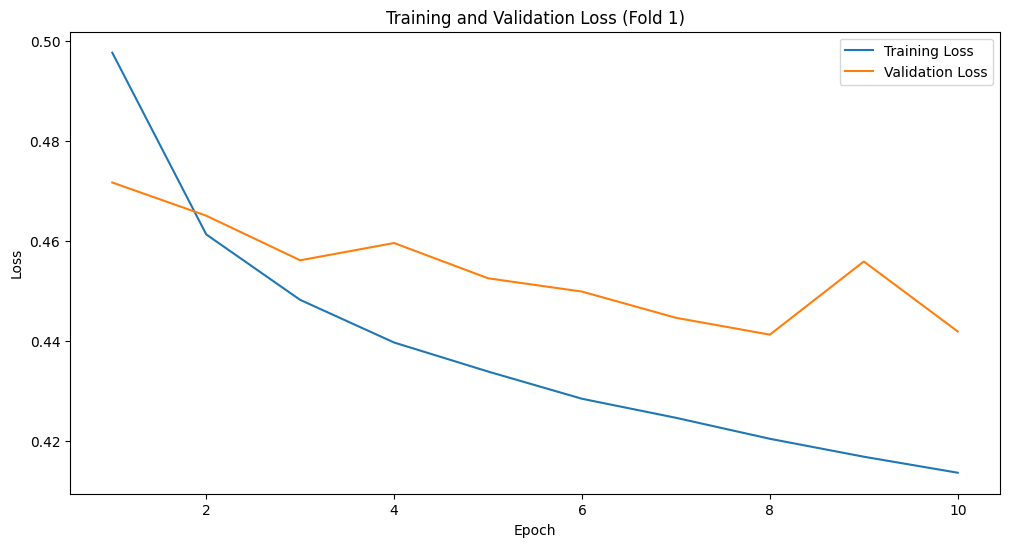

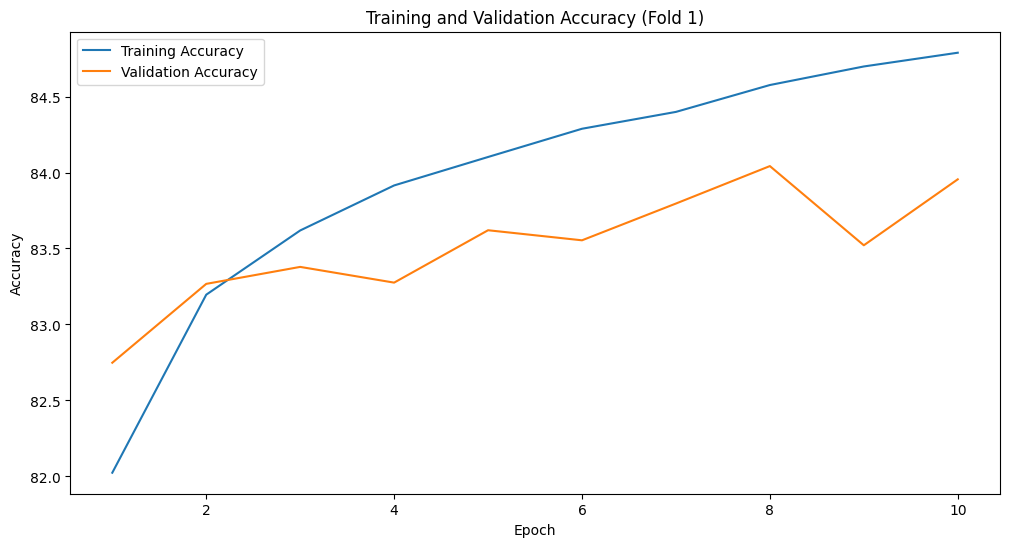

/tmp/ipykernel_259633/1118201196.py:223: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', num_classes)


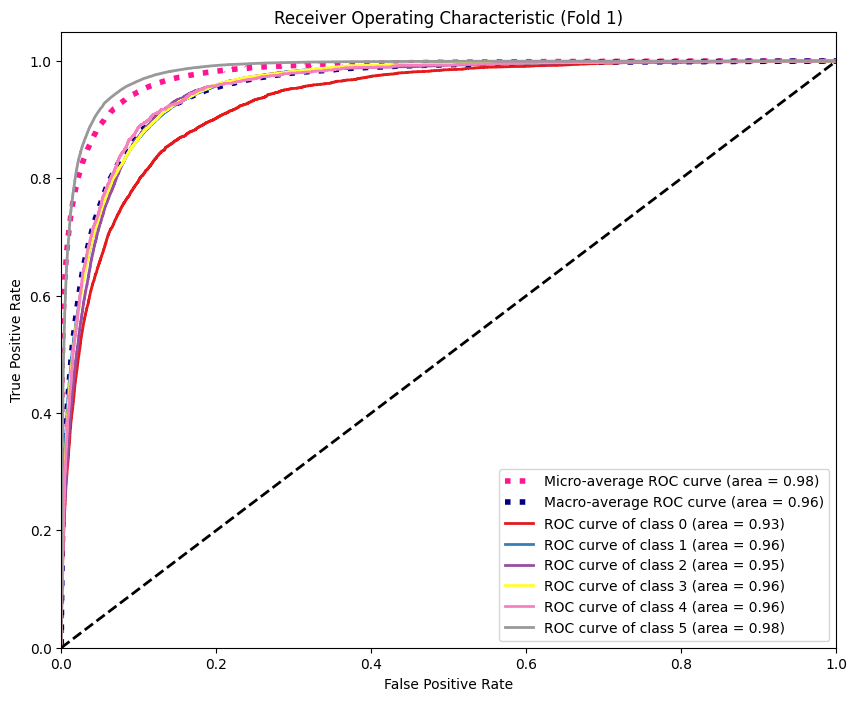

AUROC Scores:
Class 0: AUROC = 0.93
Class 1: AUROC = 0.96
Class 2: AUROC = 0.95
Class 3: AUROC = 0.96
Class 4: AUROC = 0.96
Class 5: AUROC = 0.98
Micro-average AUROC: 0.98
Macro-average AUROC: 0.96
Results for fold 1 saved to /mnt/disks/ecdyer-disk1/results//results_fold_1.parquet

Fold 2/3
--------------------------------
Epoch [1/10], Training Loss: 0.4981, Training Accuracy: 81.99%, Validation Loss: 0.4723, Validation Accuracy: 82.61%
Epoch [2/10], Training Loss: 0.4624, Training Accuracy: 83.19%, Validation Loss: 0.4582, Validation Accuracy: 83.22%
Epoch [3/10], Training Loss: 0.4491, Training Accuracy: 83.64%, Validation Loss: 0.4627, Validation Accuracy: 83.12%
Epoch [4/10], Training Loss: 0.4403, Training Accuracy: 83.95%, Validation Loss: 0.4528, Validation Accuracy: 83.64%
Epoch [5/10], Training Loss: 0.4343, Training Accuracy: 84.15%, Validation Loss: 0.4470, Validation Accuracy: 83.70%
Epoch [6/10], Training Loss: 0.4285, Training Accuracy: 84.34%, Validation Loss: 0.4469, V

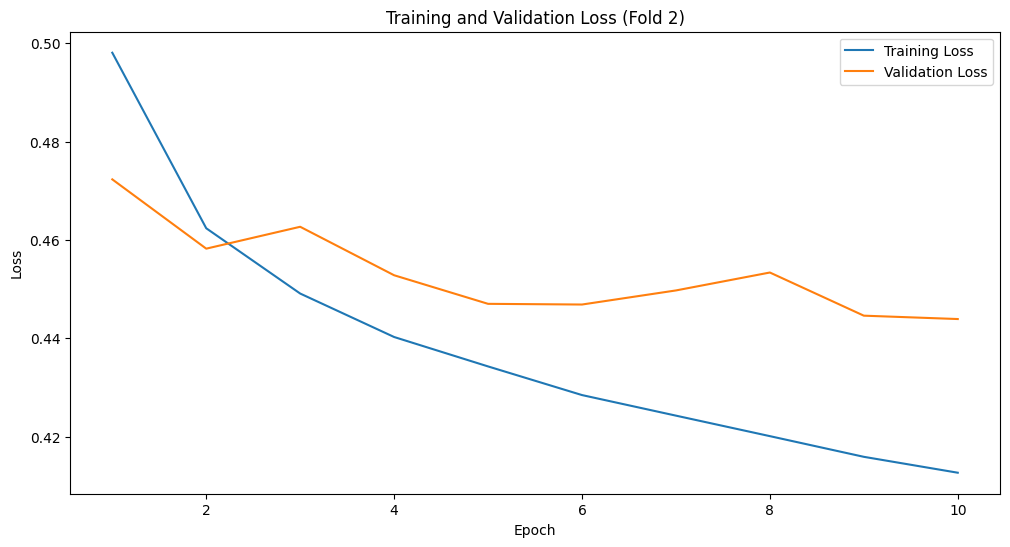

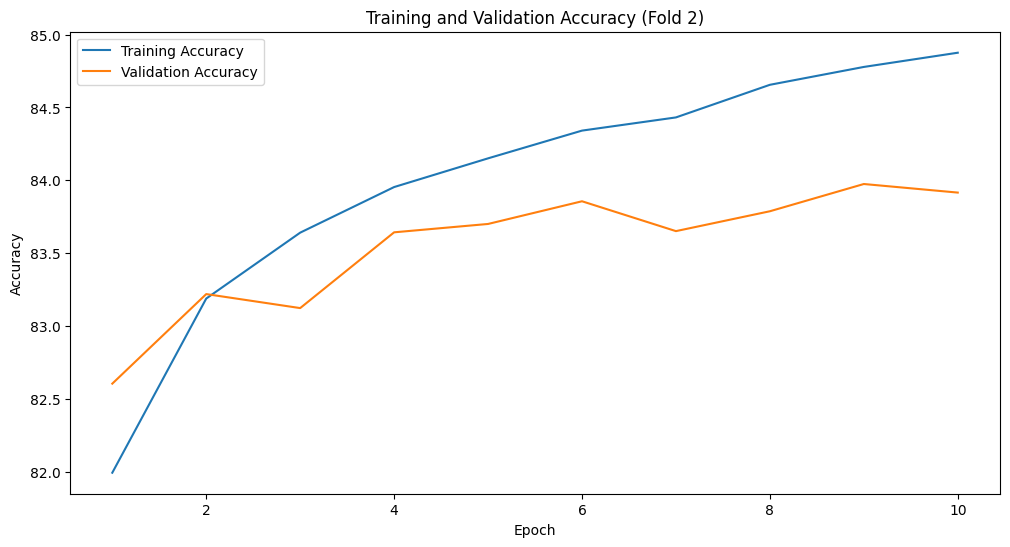

/tmp/ipykernel_259633/1118201196.py:223: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', num_classes)


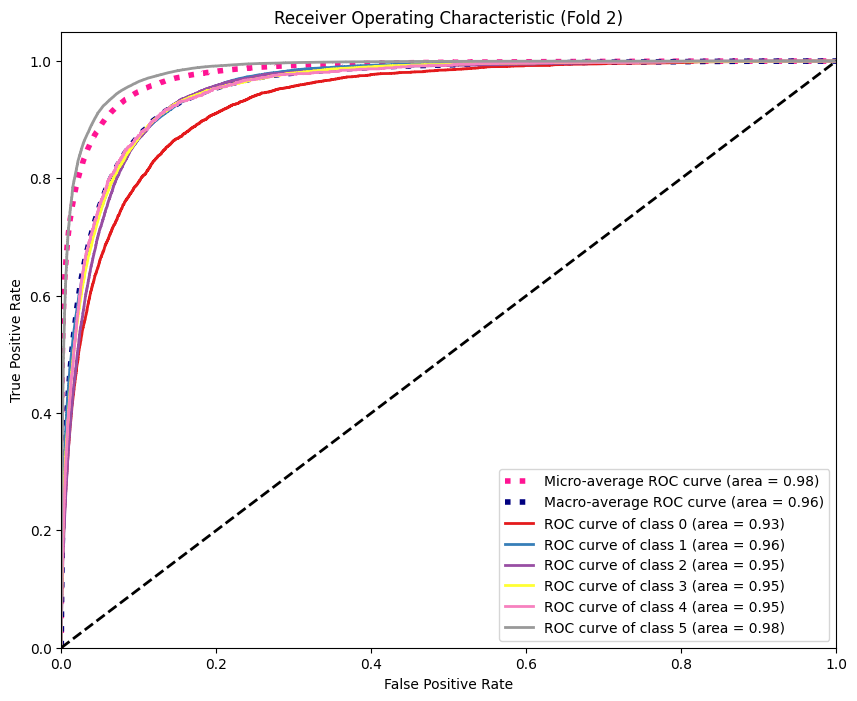

AUROC Scores:
Class 0: AUROC = 0.93
Class 1: AUROC = 0.96
Class 2: AUROC = 0.95
Class 3: AUROC = 0.95
Class 4: AUROC = 0.95
Class 5: AUROC = 0.98
Micro-average AUROC: 0.98
Macro-average AUROC: 0.96
Results for fold 2 saved to /mnt/disks/ecdyer-disk1/results//results_fold_2.parquet

Fold 3/3
--------------------------------
Epoch [1/10], Training Loss: 0.5000, Training Accuracy: 82.02%, Validation Loss: 0.4674, Validation Accuracy: 82.93%
Epoch [2/10], Training Loss: 0.4630, Training Accuracy: 83.07%, Validation Loss: 0.4562, Validation Accuracy: 83.35%
Epoch [3/10], Training Loss: 0.4498, Training Accuracy: 83.54%, Validation Loss: 0.4547, Validation Accuracy: 83.35%
Epoch [4/10], Training Loss: 0.4416, Training Accuracy: 83.78%, Validation Loss: 0.4455, Validation Accuracy: 83.74%
Epoch [5/10], Training Loss: 0.4353, Training Accuracy: 84.06%, Validation Loss: 0.4434, Validation Accuracy: 83.86%
Epoch [6/10], Training Loss: 0.4297, Training Accuracy: 84.28%, Validation Loss: 0.4477, V

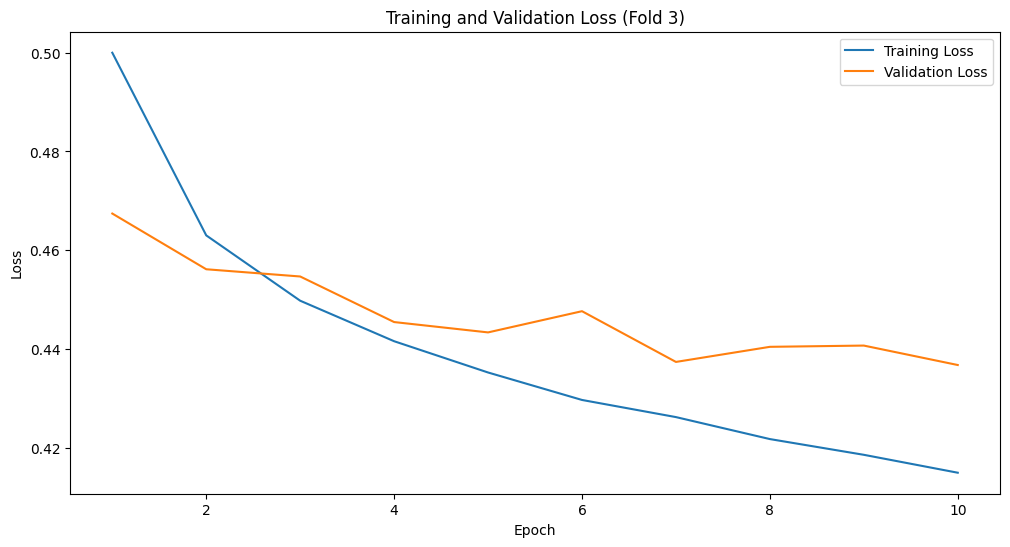

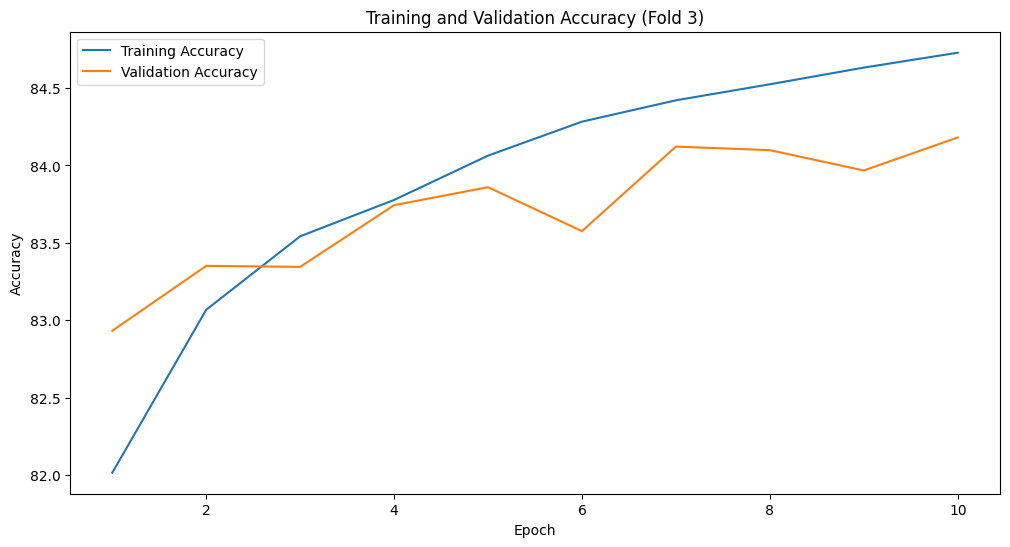

/tmp/ipykernel_259633/1118201196.py:223: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', num_classes)


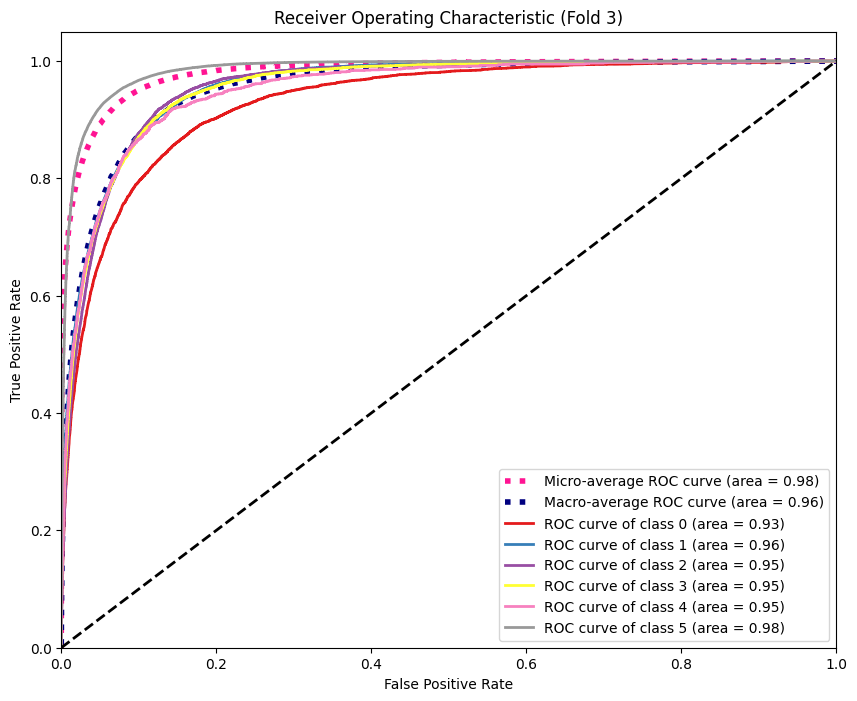

AUROC Scores:
Class 0: AUROC = 0.93
Class 1: AUROC = 0.96
Class 2: AUROC = 0.95
Class 3: AUROC = 0.95
Class 4: AUROC = 0.95
Class 5: AUROC = 0.98
Micro-average AUROC: 0.98
Macro-average AUROC: 0.96
Results for fold 3 saved to /mnt/disks/ecdyer-disk1/results//results_fold_3.parquet

Cross-validation completed.
Overall best model saved.


In [77]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Initialize variables to track the overall best model
overall_best_accuracy = 0.0
overall_best_model_wts = None

# Set up k-fold cross validation
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Start cross-validation
for fold, (train_ids, test_ids) in enumerate(kfold.split(training_dataset)):
    print(f'Fold {fold + 1}/{num_folds}')
    print('--------------------------------')

    # Sample subsets for training and testing
    train_subsampler = Subset(training_dataset, train_ids)
    test_subsampler = Subset(training_dataset, test_ids)

    # Data loaders
    train_loader = DataLoader(train_subsampler, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_subsampler, batch_size=batch_size, shuffle=False)

    # Initialize the model, loss function, and optimizer
    model = SimpleMLP(input_size, hidden_size, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Initialize variables to track the best model in this fold
    best_accuracy = 0.0
    best_model_wts = None

    # Initialize lists to track metrics for visualization
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch_embeddings, batch_labels in train_loader:
            batch_embeddings = batch_embeddings.to(device)
            batch_labels = batch_labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(batch_embeddings)
            loss = criterion(outputs, batch_labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * batch_embeddings.size(0)

            # Calculate accuracy for training batch
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == batch_labels).sum().item()
            total_train += batch_labels.size(0)

        # Calculate average training loss and accuracy for the epoch
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_accuracy = 100 * correct_train / total_train
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)

        # Evaluation on the validation set
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for batch_embeddings, batch_labels in test_loader:
                batch_embeddings = batch_embeddings.to(device)
                batch_labels = batch_labels.to(device)

                outputs = model(batch_embeddings)
                loss = criterion(outputs, batch_labels)
                running_val_loss += loss.item() * batch_embeddings.size(0)

                # Calculate accuracy for validation batch
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == batch_labels).sum().item()
                total_val += batch_labels.size(0)

        # Calculate average validation loss and accuracy for the epoch
        epoch_val_loss = running_val_loss / len(test_loader.dataset)
        epoch_val_accuracy = 100 * correct_val / total_val
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_accuracy)

        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Training Loss: {epoch_train_loss:.4f}, Training Accuracy: {epoch_train_accuracy:.2f}%, '
              f'Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_accuracy:.2f}%')

        # Check if this is the best model so far in this fold
        if epoch_val_accuracy > best_accuracy:
            best_accuracy = epoch_val_accuracy
            best_model_wts = model.state_dict().copy()
            # Optionally, save the model immediately
            torch.save(best_model_wts, f'best_model_fold_{fold + 1}.pth')

    print(f'Best Validation Accuracy for fold {fold + 1}: {best_accuracy:.2f}%')

    # Save the best model of this fold
    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)
        torch.save(model.state_dict(), f'best_model_fold_{fold + 1}.pth')
        print(f'Best model for fold {fold + 1} saved.')
    else:
        print(f'No improvement observed during training for fold {fold + 1}.')

    # Update the overall best model if necessary
    if best_accuracy > overall_best_accuracy:
        overall_best_accuracy = best_accuracy
        overall_best_model_wts = best_model_wts.copy()
        torch.save(overall_best_model_wts, 'best_model_overall.pth')
        print('Overall best model updated and saved.')

    # Plot Training and Validation Loss
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss (Fold {fold + 1})')
    plt.legend()
    plt.savefig(output_dir + '/' + f'loss_fold_{fold + 1}.png', dpi=300)
    plt.show()
    plt.close()

    # Plot Training and Validation Accuracy
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Training and Validation Accuracy (Fold {fold + 1})')
    plt.legend()
    plt.savefig(output_dir + '/' + f'accuracy_fold_{fold + 1}.png', dpi=300)
    plt.show()
    plt.close()

    # Evaluate the model on the test set and save results
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for batch_embeddings, batch_labels in test_loader:
            batch_embeddings = batch_embeddings.to(device)
            batch_labels = batch_labels.to(device)

            outputs = model(batch_embeddings)
            probabilities = torch.softmax(outputs, dim=1)  # Predicted probabilities

            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())
            all_probs.extend(probabilities.cpu().numpy())

    # Compute AUROC and plot ROC curve
    # Binarize the true labels
    all_labels_binarized = label_binarize(all_labels, classes=np.arange(num_classes))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(all_labels_binarized[:, i], np.array(all_probs)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(all_labels_binarized.ravel(), np.array(all_probs).ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area
    # Aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

    # Interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Average it and compute AUC
    mean_tpr /= num_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(10, 8))

    plt.plot(fpr["micro"], tpr["micro"],
             label='Micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='Macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = plt.cm.get_cmap('Set1', num_classes)
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], color=colors(i), lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (Fold {fold + 1})')
    plt.legend(loc="lower right")
    plt.savefig(output_dir + '/' + f'roc_fold_{fold + 1}.png', dpi=300)
    plt.show()
    plt.close()

    # Print AUROC scores
    print('AUROC Scores:')
    for i in range(num_classes):
        print(f'Class {i}: AUROC = {roc_auc[i]:0.2f}')
    print(f'Micro-average AUROC: {roc_auc["micro"]:0.2f}')
    print(f'Macro-average AUROC: {roc_auc["macro"]:0.2f}')

    # Save the results as a parquet file
    results_df = pd.DataFrame({
        'TrueLabel': all_labels,
        'PredictedLabel': all_preds
    })
    parquet_file_path = output_dir + '/' + f'results_fold_{fold + 1}.parquet'
    results_df.to_parquet(parquet_file_path, index=False)
    print(f'Results for fold {fold + 1} saved to {parquet_file_path}\n')

print('Cross-validation completed.')

# After cross-validation, save the overall best model
if overall_best_model_wts is not None:
    # Initialize the model architecture
    model = SimpleMLP(input_size, hidden_size, num_classes).to(device)
    model.load_state_dict(overall_best_model_wts)
    torch.save(model.state_dict(), 'best_model_overall.pth')
    print('Overall best model saved.')
else:
    print('No overall best model was found.')


#### Evaluate Best Model on Validation Set and Held Out Set for Visualization

In [89]:
### VALIDATION SET ###

# Load the best model architecture
model = SimpleMLP(input_size, hidden_size, num_classes).to(device)
model.load_state_dict(torch.load('/mnt/disks/ecdyer-disk1/Deep-Learning-on-Multiplexed-Immunofluorescence/autogate_models/best_model_overall.pth'))

# Set the model to evaluation mode
model.eval()

# Load the Validation Dataset
embeddings = torch.tensor(adata_10.X, dtype=torch.float32).to(device)
labels = torch.tensor(adata_10.obs['updated_phenotypes'].cat.codes.values, dtype=torch.long).to(device)

# Create Dataset
validation_dataset = mIFDataset(embeddings, labels)

# Load the test data
val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

/tmp/ipykernel_259633/4250719758.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/mnt/disks/ecdyer-disk1/Deep-Learning-on-Multiplexed-I

In [91]:
#### VISUALIZATION VALIDATION SET ####
viz_data = ad.read_h5ad('/mnt/disks/ecdyer-disk1/data/validation-viz-region.h5ad')

# Drop all 'unassigned' cells
viz_data = viz_data[viz_data.obs['updated_phenotypes'] != 'unassigned']

# Load the Validation Dataset
embeddings = torch.tensor(viz_data.X, dtype=torch.float32).to(device)
labels = torch.tensor(viz_data.obs['updated_phenotypes'].cat.codes.values, dtype=torch.long).to(device)

# Create Dataset
validation_dataset = mIFDataset(embeddings, labels)

# Load the test data
val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

In [83]:
# Recover the string labels
categories = adata_10.obs['updated_phenotypes'].cat.categories
int_to_str_labels = {i: label for i, label in enumerate(categories)}

# Example: Print the mapping
print("Integer to String Label Mapping:")
for int_label, str_label in int_to_str_labels.items():
    print(f"{int_label}: {str_label}")

# Example: Convert integer labels back to string labels
int_labels = labels.cpu().numpy()  # Convert to numpy array if needed
str_labels = [int_to_str_labels[int_label] for int_label in int_labels]

# Example: Print the first 10 string labels
print("First 10 String Labels:")
print(str_labels[:10])

Integer to String Label Mapping:
0: Cytotoxic T cells
1: Dendritic cell
2: Exhuasted T cells
3: M2 Macrophage
4: Treg 
5: Tumor
First 10 String Labels:
['Tumor', 'Tumor', 'Dendritic cell', 'Dendritic cell', 'Tumor', 'Tumor', 'Tumor', 'Exhuasted T cells', 'Tumor', 'Tumor']


Validation Loss: 0.4946, Validation Accuracy: 81.55%


/tmp/ipykernel_259633/403888524.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', num_classes)


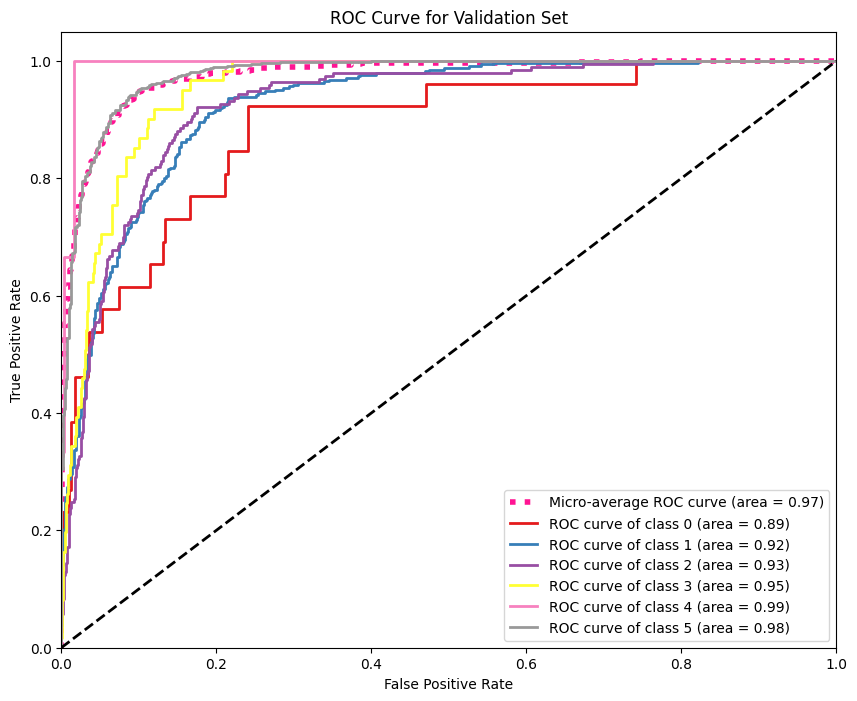

Validation results saved.


In [92]:
all_preds = []
all_labels = []
all_probs = []
running_val_loss = 0.0
correct_val = 0
total_val = 0
output_dir = '/mnt/disks/ecdyer-disk1/autogate_viz_results/'

with torch.no_grad():
    for batch_embeddings, batch_labels in val_loader:
        batch_embeddings = batch_embeddings.to(device)
        batch_labels = batch_labels.to(device)

        outputs = model(batch_embeddings)
        loss = criterion(outputs, batch_labels)
        running_val_loss += loss.item() * batch_embeddings.size(0)

        probabilities = torch.softmax(outputs, dim=1)  # Predicted probabilities
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())
        all_probs.extend(probabilities.cpu().numpy())

        correct_val += (predicted == batch_labels).sum().item()
        total_val += batch_labels.size(0)

# Calculate accuracy and loss for the entire validation dataset
val_loss = running_val_loss / len(val_loader.dataset)
val_accuracy = 100 * correct_val / total_val
print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

# Binarize the labels for ROC calculation
all_labels_binarized = label_binarize(all_labels, classes=np.arange(num_classes))

# Compute ROC curve and AUROC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_binarized[:, i], np.array(all_probs)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUROC
fpr["micro"], tpr["micro"], _ = roc_curve(all_labels_binarized.ravel(), np.array(all_probs).ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
colors = plt.cm.get_cmap('Set1', num_classes)
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors(i), lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Validation Set')
plt.legend(loc="lower right")
plt.savefig(output_dir + '/roc_validation.png', dpi=300)
plt.show()

# Save results
results_df = pd.DataFrame({
    'TrueLabel': all_labels,
    'PredictedLabel': all_preds
})
# Define the mapping from integer labels to cell types
label_mapping = {
    0: 'Cytotoxic T cells',
    1: 'Dendritic cell',
    2: 'Exhausted T cells',
    3: 'M2 Macrophage',
    4: 'Treg',
    5: 'Tumor'
}

# Map the 'PredictedLabel' values to the cell types
results_df['predicted_cell_type'] = results_df['PredictedLabel'].map(label_mapping)
results_df['true_cell_type'] = results_df['TrueLabel'].map(label_mapping)
results_df.to_parquet(output_dir + '/' + 'validation_results.parquet', index=False)
print('Validation results saved.')
